# <center>Project-Based Assignment CLO-2</center>

<b>Topik</b>
Implementation of Supervised Learning on Regression Task

<b>Anggota Kelompok</b>
1. Chairunnisa Mahadewi Budi Santosa - 1301213104
2. Dian Syafilla                     - 1301213229
3. Syifa Fatimah Azzahra             - 1301213487

# Latar Belakang

Untuk projek CLO 2: Supervised Learning on Regression Task, kami memilih Multivariate Gait Data yang merupakan *six dimentional* dataset (10 subjek, 3 kondisi, 10 kali perulangan, 2 kaki, 3 sendi, dan 101 waktu) dari data *joint angle*. Data ini didapatkan dari hasil studi atas 10 subjek dengan 3 kondisi berbeda, yaitu normal (*unbraced*), *knee-braced* di lutut kanan, dan *ankle-braced* di pergelangan kaki kanan di atas *treadmill*.

Pada setiap subjek dan kondisi, siklus gait dilakukan sebanyak 10 kali perulangan dimana setiap siklus dimulai dan diakhiri dengan *heel-strike* (tumit menyentuh lantai terlebih dahulu). Waktu di semua siklus dinormalisasikan menjadi 101 waktu yang merepresentasikan 0%, ..., 100% siklus gait. *Joint angle* yang disertakan merupakan kombinasi dari kaki (kiri dan kanan) serta sendi (pergelangan kaki, lutut, dan pinggul).

Tipe data yang digunakan pada 6 *features* adalah kategorik (*sequential*) dan 1 *feature* bertipe *real*. Totalnya terdapat 7 *features* dengan 181800 *instances* tanpa missing value.

Kami akan mengolah dan melatih dataset ini untuk kemudian melakukan prediksi terhadap besar *angle* (sudut) berdasarkan besaran *angle* sebelumnya (*univariate*) dan perhitungan *features* lainnya (*multivariate*) dengan menggunakan pendekatan RNN, GRU, dan LSTM. Diantara ketiga pendekatan sebelumnya, kami akan melihat pendekatan mana yang paling tepat dalam prediksinya.

#Import Library & Dataset  

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [ ]:
url = "https://drive.google.com/uc?id=1rObfPZanjgRLXKv5CA0TZM91uIWI1_qQ"
df = pd.read_csv(url)
df

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399
...,...,...,...,...,...,...,...
181795,10,3,10,2,3,96,29.778412
181796,10,3,10,2,3,97,29.247559
181797,10,3,10,2,3,98,28.796951
181798,10,3,10,2,3,99,28.432936


**Deskripsi Features pada Database**
1. Subject: 1 = subject 1, …, 10 = subject 10 (integer)
2. Condition: 1 = unbraced, 2 = knee brace, 3 = ankle brace (integer)
3. Replication: 1 = replication 1, …, 10 = replication 10 (integer)
4. Leg: 1 = left, 2 = right (integer)
5. Joint: 1 = ankle, 2 = knee, 3 = hip (integer)
6. Time: 0 = 0% gait cycle, …, 100 = 100% gait cycle (integer)
7. Angle: joint angle in degrees (real valued)

#Ringakasan Metode

Berdasarkan hasil eksplorasi data, kami melihat bahwasannya dataset kami bersifat *time-sequence*, sehingga lebih cocok apabila menggunakan pedekatan RNN. Sebagai pembanding, kami juga menggunakan 2 pendekatan lainnya yang efektif dalam menangani data *time-sequence*, yaitu GRU dan LSTM.

###Data Eksplorasi

In [ ]:
# mengambil data dari subjek 1 dan kondisi 1
df = df[(df['subject'] == 1) & (df['condition'] == 1)]
df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


<Axes: >

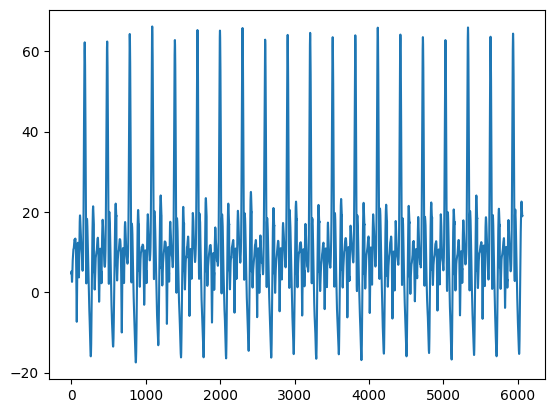

In [ ]:
# membuat plot dari data df yang sebelumnya dan dibandingkan dengan angle
temp = df[(df['subject'] == 1) & (df['condition'] == 1)]['angle']
temp.plot()

##Univariate Time Series

###Data Preprocessing

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

# untuk transpose data
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

In [ ]:
X_train1, y_train1 = X1[:5000], y1[:5000]
X_val1, y_val1 = X1[5000:5500], y1[5000:5500]
X_test1, y_test1 = X1[5500:], y1[5500:]

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

###RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(SimpleRNN(64))
model1.add(Dense(8, 'sigmoid'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4753 (18.57 KB)
Trainable params: 4753 (18.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
157/157 [==============================] - 6s 20ms/step - loss: 296.3874 - root_mean_squared_error: 17.2159 - val_loss: 338.8958 - val_root_mean_squared_error: 18.4091
Epoch 2/20
157/157 [==============================] - 3s 17ms/step - loss: 272.9381 - root_mean_squared_error: 16.5208 - val_loss: 317.3168 - val_root_mean_squared_error: 17.8134
Epoch 3/20
157/157 [==============================] - 3s 17ms/step - loss: 254.7962 - root_mean_squared_error: 15.9623 - val_loss: 298.4162 - val_root_mean_squared_error: 17.2747
Epoch 4/20
157/157 [==============================] - 3s 21ms/step - loss: 238.7148 - root_mean_squared_error: 15.4504 - val_loss: 281.3784 - val_root_mean_squared_error: 16.7743
Epoch 5/20
157/157 [==============================] - 4s 25ms/step - loss: 224.6148 - root_mean_squared_error: 14.9872 - val_loss: 265.9818 - val_root_mean_squared_error: 16.3089
Epoch 6/20
157/157 [==============================] - 3s 16ms/step - loss: 211.8086 - root_mean_squared_e

18/18 [==============================] - 0s 3ms/step


(     Predictions    Actuals
 0      12.137651  12.268267
 1      12.260180  12.374724
 2      12.349058  12.446154
 3      12.394329  12.475420
 4      12.392332  12.458861
 ..           ...        ...
 550    18.429239  19.639531
 551    18.288799  19.222357
 552    18.157724  18.974241
 553    18.105467  18.908536
 554    18.141283  19.003468
 
 [555 rows x 2 columns],
 122.96610420964448)

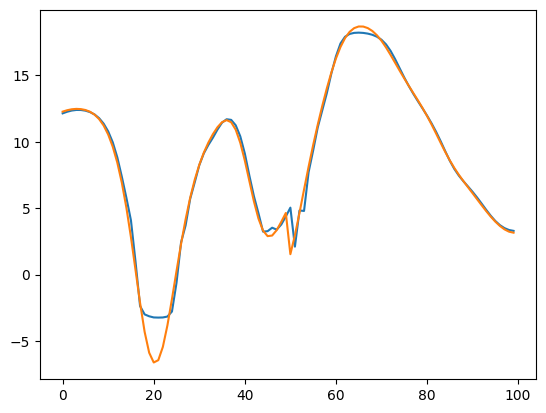

In [ ]:
plot_predictions1(model1, X_test1, y_test1)

###GRU

In [ ]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(GRU(64))
model2.add(Dense(8, 'sigmoid'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp2])

Epoch 1/20
157/157 [==============================] - 10s 43ms/step - loss: 311.0916 - root_mean_squared_error: 17.6378 - val_loss: 349.8925 - val_root_mean_squared_error: 18.7054
Epoch 2/20
157/157 [==============================] - 5s 31ms/step - loss: 281.9396 - root_mean_squared_error: 16.7911 - val_loss: 325.9911 - val_root_mean_squared_error: 18.0552
Epoch 3/20
157/157 [==============================] - 6s 36ms/step - loss: 262.0756 - root_mean_squared_error: 16.1887 - val_loss: 305.7049 - val_root_mean_squared_error: 17.4844
Epoch 4/20
157/157 [==============================] - 6s 41ms/step - loss: 245.0511 - root_mean_squared_error: 15.6541 - val_loss: 287.8030 - val_root_mean_squared_error: 16.9648
Epoch 5/20
157/157 [==============================] - 5s 31ms/step - loss: 230.1304 - root_mean_squared_error: 15.1700 - val_loss: 272.0328 - val_root_mean_squared_error: 16.4934
Epoch 6/20
157/157 [==============================] - 7s 44ms/step - loss: 216.9178 - root_mean_squared_

18/18 [==============================] - 0s 3ms/step


(     Predictions    Actuals
 0      12.226942  12.268267
 1      12.354655  12.374724
 2      12.443510  12.446154
 3      12.482312  12.475420
 4      12.467919  12.458861
 ..           ...        ...
 550    18.163742  19.639531
 551    18.110464  19.222357
 552    18.029003  18.974241
 553    17.973120  18.908536
 554    17.987749  19.003468
 
 [555 rows x 2 columns],
 124.96923727868426)

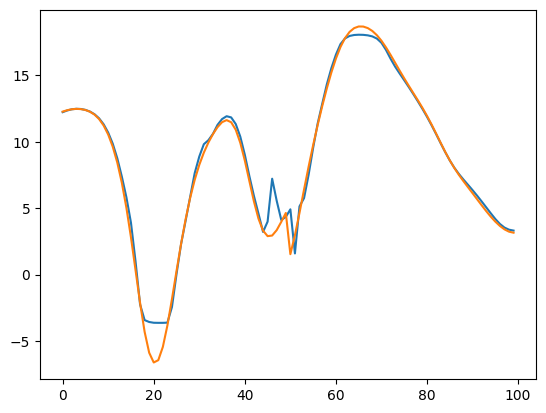

In [ ]:
plot_predictions1(model2, X_test1, y_test1)

###LSTM

In [ ]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'sigmoid'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
157/157 [==============================] - 10s 43ms/step - loss: 302.6956 - root_mean_squared_error: 17.3982 - val_loss: 338.8709 - val_root_mean_squared_error: 18.4084
Epoch 2/20
157/157 [==============================] - 6s 37ms/step - loss: 272.1213 - root_mean_squared_error: 16.4961 - val_loss: 316.2929 - val_root_mean_squared_error: 17.7846
Epoch 3/20
157/157 [==============================] - 6s 40ms/step - loss: 253.3030 - root_mean_squared_error: 15.9155 - val_loss: 296.7170 - val_root_mean_squared_error: 17.2255
Epoch 4/20
157/157 [==============================] - 5s 32ms/step - loss: 237.1857 - root_mean_squared_error: 15.4008 - val_loss: 279.7406 - val_root_mean_squared_error: 16.7254
Epoch 5/20
157/157 [==============================] - 7s 44ms/step - loss: 222.9947 - root_mean_squared_error: 14.9330 - val_loss: 264.4496 - val_root_mean_squared_error: 16.2619
Epoch 6/20
157/157 [==============================] - 6s 35ms/step - loss: 210.3849 - root_mean_squared_

18/18 [==============================] - 1s 5ms/step


(     Predictions    Actuals
 0      12.184061  12.268267
 1      12.301226  12.374724
 2      12.382006  12.446154
 3      12.417694  12.475420
 4      12.406445  12.458861
 ..           ...        ...
 550    18.291870  19.639531
 551    17.969915  19.222357
 552    17.704433  18.974241
 553    17.593288  18.908536
 554    17.637383  19.003468
 
 [555 rows x 2 columns],
 122.76672640257745)

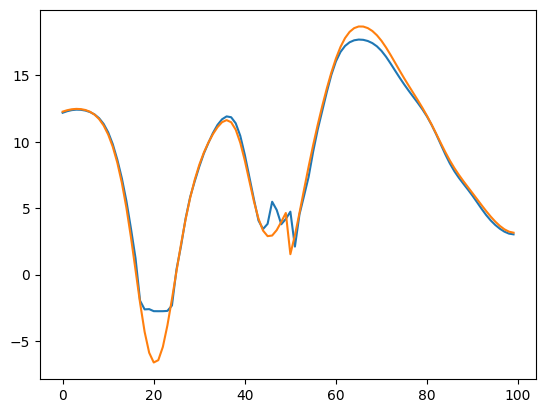

In [ ]:
plot_predictions1(model3, X_test1, y_test1)

##Multivariate Time Series

###Data Preprocessing

In [ ]:
ang = df[(df['subject'] == 1) & (df['condition'] == 1)]['angle']
rep = df[(df['subject'] == 1) & (df['condition'] == 1)]['replication']
leg = df[(df['subject'] == 1) & (df['condition'] == 1)]['leg']
joi = df[(df['subject'] == 1) & (df['condition'] == 1)]['joint']
tim = df[(df['subject'] == 1) & (df['condition'] == 1)]['time']

In [ ]:
temp_df = pd.DataFrame({'Angle':ang, 'Repetition': rep, 'Leg': leg, 'Joint' : joi, 'Time': tim})
temp_df

,Angle,Repetition,Leg,Joint,Time
0,4.682881,1,1,1,0
1,5.073127,1,1,1,1
2,5.229774,1,1,1,2
3,5.083273,1,1,1,3
4,4.652399,1,1,1,4
...,...,...,...,...,...
6055,19.639531,10,2,3,96
6056,19.222357,10,2,3,97
6057,18.974241,10,2,3,98
6058,18.908536,10,2,3,99


In [ ]:
def df_to_X_y2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((6055, 5, 5), (6055,))

In [ ]:
X2_train, y2_train = X2[:5000], y2[:5000]
X2_val, y2_val = X2[5000:5500], y2[5000:5500]
X2_test, y2_test = X2[5500:], y2[5500:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((5000, 5, 5), (5000,), (500, 5, 5), (500,), (555, 5, 5), (555,))

###RNN

In [ ]:
model4 = Sequential()
model4.add(InputLayer((5, 5)))
model4.add(SimpleRNN(128))
model4.add(Dense(16, 'sigmoid'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 128)               17152     
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19233 (75.13 KB)
Trainable params: 19233 (75.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=20, callbacks=[cp4])

Epoch 1/20
157/157 [==============================] - 4s 19ms/step - loss: 279.9831 - root_mean_squared_error: 16.7327 - val_loss: 308.8656 - val_root_mean_squared_error: 17.5746
Epoch 2/20
157/157 [==============================] - 4s 24ms/step - loss: 240.7437 - root_mean_squared_error: 15.5159 - val_loss: 275.9102 - val_root_mean_squared_error: 16.6105
Epoch 3/20
157/157 [==============================] - 3s 19ms/step - loss: 215.0193 - root_mean_squared_error: 14.6635 - val_loss: 249.4609 - val_root_mean_squared_error: 15.7943
Epoch 4/20
157/157 [==============================] - 3s 22ms/step - loss: 194.0694 - root_mean_squared_error: 13.9309 - val_loss: 227.6463 - val_root_mean_squared_error: 15.0880
Epoch 5/20
157/157 [==============================] - 3s 17ms/step - loss: 176.8599 - root_mean_squared_error: 13.2989 - val_loss: 209.0142 - val_root_mean_squared_error: 14.4573
Epoch 6/20
157/157 [==============================] - 3s 19ms/step - loss: 162.3569 - root_mean_squared_e

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

###GRU

In [ ]:
model5 = Sequential()
model5.add(InputLayer((5, 5)))
model5.add(GRU(128))
model5.add(Dense(16, 'sigmoid'))
model5.add(Dense(1, 'linear'))

model5.summary()

In [ ]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=20, callbacks=[cp4])

In [ ]:
plot_predictions1(model5, X2_test, y2_test)

###LSTM

In [ ]:
model6 = Sequential()
model6.add(InputLayer((5, 5)))
model6.add(LSTM(128))
model6.add(Dense(16, 'sigmoid'))
model6.add(Dense(1, 'linear'))

model6.summary()

In [ ]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=20, callbacks=[cp4])

In [ ]:
plot_predictions1(model6, X2_test, y2_test)

# Kesimpulan

Berdasarkan ketiga metode yang digunakan, dapat diketahui bahwa pendekatan yang paling tepat merupakan pendekatan LSTM dengan ujicoba multivariate. Hal ini dikarenakan, pada ujicoba univariate, data yang digunakan sebagai data acuan hanya merupakan *features* angle. Sedangkan pada ujicoba multivariate, data yang digunakan terdiri dari beberapa *features*, sehingga, hasil prediksinya pun lebih tepat.

Mengapa diantara ketiga metode LSTM merupakan pendekatan yang paling akurat? Karena LSTM memiliki kemampuan untuk mengingat (karena memiliki input-output gate), sehingga cocok mengolah dataset time-sequence yang panjang. Berbeda dengan RNN yang kurang optimal dalam mengingat dan GRU juga kurang akurat untuk dataset ini.